In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from utils import iter_df_read, get_array_diff
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
sns.set(font_scale=1.5)

# Modificar por ruta local de almacenamiento de datos
BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Operacionalización de datos

### Alumno desertor
- Requisito: No se debe haber titulado para la carrera analizada

### Tipos de deserción

- Sale del sistema y no vuelve a ingresar
- Sale del sistema y vuelve después de 1, 2 ó 3 años a la misma carrera en la misma institución (no deserta, "congela")
- Sale y vuelve a otra carrera en la misma institución (seudo deserción?)
- Sale y vuelve a la misma carrera en otra institución (seudo deserción?)
- Sale y vuelve a otra carrera en otra institución (seudo deserción?)
- Sale del sistema, vuelve a ingresar, pero no termina ni se matricula 2022 (múltiple deserción?)

# Matriculados

## Lectura de datos matriculados

Fuente: https://datosabiertos.mineduc.cl/matricula-en-educacion-superior/

- Se considera todos los matriculados en CFT / IP desde 2015

In [2]:
# Matriculados de CFT / IP entre 2015 y 2022
mat_cft_ip = pd.read_csv(f"{BASE}/tmp_data/fechas_titulacion.csv", usecols=["codigo_unico", "mrun", "fecha_obtencion_titulo"])
mat_cft_ip.head()

,codigo_unico,mrun,fecha_obtencion_titulo
0,I143S26C9J2V2,26379527.0,20220228.0
1,I117S1C69J4V1,21154360.0,20220228.0
2,I143S28C651J4V1,1695886.0,20220228.0
3,I143S28C9J4V1,1695588.0,20220228.0
4,I241S1C10J1V1,1675681.0,20220228.0


In [3]:
mat_cft_ip.isna().sum()

codigo_unico                    0
mrun                            0
fecha_obtencion_titulo    1103558
dtype: int64

In [4]:
# Se carga datos de matrícula para estos alumnos, considerando todas las instituciones
cols = [
    'cat_periodo', 'codigo_unico', 'mrun', 'tipo_inst_1', 'dur_estudio_carr',
    'cod_inst', 'cod_carrera'
]

mruns = mat_cft_ip["mrun"].unique()

matriculados = pd.concat([
    iter_df_read(f, "mrun", mruns, sep=";", usecols=cols)
    for f in tqdm(
        glob(f"{BASE}/raw_data/post_2015/20220719_Matrícula_Ed_Superior_*.csv"),
        total=8
    )
]).drop_duplicates().reset_index(drop=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
# Se agrega columna que indica titulación

if "fecha_obtencion_titulo" not in matriculados.columns:
    len_or = matriculados.shape[0]
    matriculados = pd.merge(
        matriculados,
        mat_cft_ip,
        how="left"
    )
    
    assert matriculados.shape[0] == len_or

## Pre procesamiento: Año de titulación 

### Por carrera

In [6]:
matriculados["anio_titulacion"] = matriculados["fecha_obtencion_titulo"].fillna("").astype(str).str[:4].replace([""], [np.nan]).astype(float)
matriculados["anio_titulacion"].describe().round()

count    1033486.0
mean        2019.0
std            1.0
min         2015.0
25%         2018.0
50%         2019.0
75%         2021.0
max         2022.0
Name: anio_titulacion, dtype: float64

### Cualquier carrera

In [7]:
tit_cualquier_carrera = matriculados[
    matriculados["anio_titulacion"].notna()
]["mrun"].unique()

matriculados["titulado_cualquier_carrera"] = np.where(matriculados["mrun"].isin(tit_cualquier_carrera), 1, 0)
matriculados["titulado_cualquier_carrera"].describe().round()

count    3476634.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            1.0
max            1.0
Name: titulado_cualquier_carrera, dtype: float64

## Pre procesamiento: Último año de matrícula 

### Por carrera

In [8]:
if "ultimo_anio_matricula" not in matriculados.columns:
    len_or = matriculados.shape[0]
    matriculados = pd.merge(
        matriculados,
        matriculados.groupby(["mrun", "codigo_unico"]).agg({
            "cat_periodo": "max"
        }).reset_index().rename(columns={
            "cat_periodo": "ultimo_anio_matricula"
        }),
        how="left"
    ).drop_duplicates().reset_index(drop=True)
    
    assert matriculados.shape[0] == len_or

In [9]:
matriculados["ultimo_anio_matricula"].describe().round()

count    3476634.0
mean        2020.0
std            2.0
min         2015.0
25%         2018.0
50%         2020.0
75%         2022.0
max         2022.0
Name: ultimo_anio_matricula, dtype: float64

### Cualquier carrera

In [10]:
if "ult_anio_mat_cualquier_carrera" not in matriculados.columns:
    len_or = matriculados.shape[0]
    matriculados = pd.merge(
        matriculados,
        matriculados.groupby(["mrun"]).agg({
            "cat_periodo": "max"
        }).reset_index().rename(columns={
            "cat_periodo": "ult_anio_mat_cualquier_carrera"
        }),
        how="left"
    ).drop_duplicates().reset_index(drop=True)
    
    assert matriculados.shape[0] == len_or

In [11]:
matriculados["ult_anio_mat_cualquier_carrera"].describe().round()

count    3476634.0
mean        2020.0
std            2.0
min         2015.0
25%         2019.0
50%         2021.0
75%         2022.0
max         2022.0
Name: ult_anio_mat_cualquier_carrera, dtype: float64

## Pre procesamiento: Deserciones

In [12]:
cft_ip = ["Institutos Profesionales", "Centros de Formación Técnica"]

In [17]:
anios = []

for a in range(2015, 2022):
    m_a = matriculados[
        (matriculados["cat_periodo"]==a)
        & (matriculados["tipo_inst_1"].isin(cft_ip))
    ].copy()
    
    m_a["tmp_"] = m_a["mrun"].astype(str) + m_a["codigo_unico"]
    m_a["tmp_2"] = m_a["mrun"].astype(str) + m_a["cod_inst"].astype(str)
    m_a["tmp_3"] = m_a["mrun"].astype(str) + m_a["cod_carrera"].astype(str)
    
    # Criterio 1: Sale del sistema y no vuelve a ingresar
    m_a["desertor_1"] = np.where(
        (m_a["anio_titulacion"].isna()) & (m_a['ult_anio_mat_cualquier_carrera'] == a), 1, 0
    )
    
    # Si terminó otra carrera no es desertor
    m_a["desertor_1"] = np.where(
        (m_a['titulado_cualquier_carrera'] == 1), 0, m_a["desertor_1"]
    )
    
    # Criterio 2.1: Sale del sistema y vuelve después de 1 año a la misma carrera en la misma institución
    m_a_next_1 =  matriculados[
        (matriculados["cat_periodo"]== a + 1)
    ].copy()[["mrun", "codigo_unico", "cod_inst", "cod_carrera"]].drop_duplicates()

    m_a_next_1["tmp_"] = m_a_next_1["mrun"].astype(str) + m_a_next_1["codigo_unico"]

    m_a_next_2 =  matriculados[
        (matriculados["cat_periodo"]== a + 2)
    ].copy()[["mrun", "codigo_unico"]].drop_duplicates()

    m_a_next_2["tmp_"] = m_a_next_2["mrun"].astype(str) + m_a_next_2["codigo_unico"]

    m_a["desertor_2_1"] = np.where(
        (~m_a["tmp_"].isin(m_a_next_1["tmp_"])) & (m_a["tmp_"].isin(m_a_next_2["tmp_"])),
        1,
        0
    )
    
    # Criterio 2.2: Sale del sistema y vuelve después de 2 años a la misma carrera en la misma institución
    m_a_next_3 =  matriculados[
        (matriculados["cat_periodo"]== a + 3)
    ].copy()[["mrun", "codigo_unico"]].drop_duplicates()

    m_a_next_3["tmp_"] = m_a_next_3["mrun"].astype(str) + m_a_next_3["codigo_unico"]

    m_a["desertor_2_2"] = np.where(
        (~m_a["tmp_"].isin(m_a_next_1["tmp_"])) & (m_a["tmp_"].isin(m_a_next_3["tmp_"])),
        1,
        0
    )
    
    # Criterio 2.3: Sale del sistema y vuelve después de 3 años a la misma carrera en la misma institución
    m_a_next_4 =  matriculados[
        (matriculados["cat_periodo"]== a + 4)
    ].copy()[["mrun", "codigo_unico"]].drop_duplicates()

    m_a_next_4["tmp_"] = m_a_next_4["mrun"].astype(str) + m_a_next_4["codigo_unico"]

    m_a["desertor_2_3"] = np.where(
        (~m_a["tmp_"].isin(m_a_next_1["tmp_"])) & (m_a["tmp_"].isin(m_a_next_4["tmp_"])),
        1,
        0
    )
    
    # Criterio 3: Sale y vuelve a otra carrera en la misma institución al año siguiente
    m_a_next_1["tmp_2"] = m_a_next_1["mrun"].astype(str) + m_a_next_1["cod_inst"].astype(str)
    m_a_next_1["tmp_3"] = m_a_next_1["mrun"].astype(str) + m_a_next_1["cod_carrera"].astype(str)
    
    m_a["desertor_3"] = np.where(
        (m_a["tmp_2"].isin(m_a_next_1["tmp_2"])) & (~m_a["tmp_"].isin(m_a_next_1["tmp_"])),
        1,
        0
    )
    
    # Criterio 4: Sale y vuelve a la misma carrera en otra institución al año siguiente
    m_a["desertor_4"] = np.where(
        (m_a["tmp_3"].isin(m_a_next_1["tmp_3"])) & (~m_a["tmp_2"].isin(m_a_next_1["tmp_2"])),
        1,
        0
    )
    
    # Criterio 5: Sale y vuelve a otra carrera en otra institución al año siguiente
    m_a["desertor_5"] = np.where(
        (~m_a["tmp_3"].isin(m_a_next_1["tmp_3"])) & (~m_a["tmp_2"].isin(m_a_next_1["tmp_2"])) & (m_a["mrun"].isin(m_a_next_1["mrun"])),
        1,
        0
    )
    
    # Criterio 6: Sale y vuelve a ingresar pero no se ha titulado ni matriculado 2022
    m_a["desertor_6"] = np.where(
        (m_a["titulado_cualquier_carrera"]==0)
        & (m_a["ult_anio_mat_cualquier_carrera"] > a)
        & (m_a["ult_anio_mat_cualquier_carrera"] < 2022)
        & (m_a["desertor_1"] == 0),
        1,
        0
    )
    
    m_a = m_a.drop(columns=["tmp_", "tmp_2", "tmp_3"])
    
    anios.append(m_a)

deserciones = pd.concat(anios)

# Exploración

In [19]:
plots = []

for d in deserciones.columns[12:]:
    etiqueta = f'% {d.replace("_", " ").title()}'
    des_tmp = deserciones.groupby("cat_periodo")[d].value_counts(normalize=True).mul(100).rename(etiqueta).reset_index()
    des_tmp = des_tmp[des_tmp[d] == 1]
    des_tmp = des_tmp.drop(columns=[d] if d == "desertor_1" else [d, "cat_periodo"])
    plots.append(des_tmp)
    
df_plots = pd.concat(plots, axis=1)

In [20]:
df_plots

,cat_periodo,% Desertor 1,% Desertor 2 1,% Desertor 2 2,% Desertor 2 3,% Desertor 3,% Desertor 4,% Desertor 5,% Desertor 6
1,2015,15.682106,1.033634,0.595575,0.322753,6.606920,0.042725,5.193909,27.567356
3,2016,14.368445,1.220331,0.671797,0.312728,7.364860,0.028372,5.532315,22.940711
5,2017,13.034642,1.334472,0.619914,0.455285,7.567489,0.022665,5.706252,20.489556
7,2018,13.062208,1.399803,0.833782,0.466227,8.029467,0.018837,4.640294,21.315483
9,2019,15.068913,2.066767,1.221997,NaN,6.731064,0.016593,4.164199,19.702125
11,2020,16.939409,1.644704,NaN,NaN,4.851399,0.015631,4.207716,15.414324
13,2021,24.696973,NaN,NaN,NaN,4.611103,0.014484,4.383910,NaN


In [21]:
df_table = df_plots[["cat_periodo", '% Desertor 1', '% Desertor 3', '% Desertor 5']].copy()
df_table["cat_periodo"] = df_table["cat_periodo"] + 1
df_table

,cat_periodo,% Desertor 1,% Desertor 3,% Desertor 5
1,2016,15.682106,6.606920,5.193909
3,2017,14.368445,7.364860,5.532315
5,2018,13.034642,7.567489,5.706252
7,2019,13.062208,8.029467,4.640294
9,2020,15.068913,6.731064,4.164199
11,2021,16.939409,4.851399,4.207716
13,2022,24.696973,4.611103,4.383910


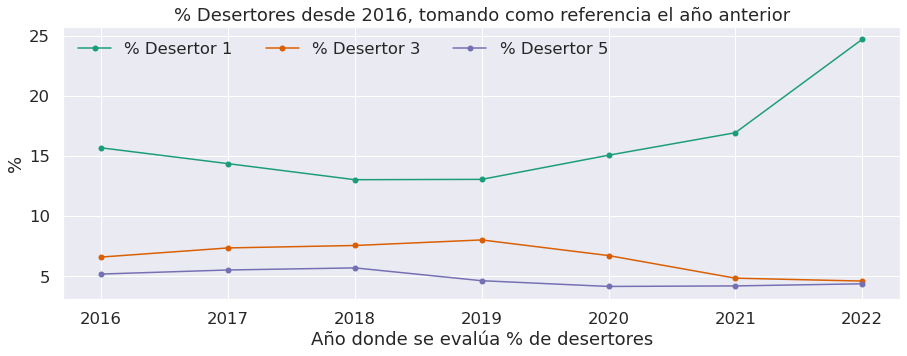

In [22]:
# ['% Desertor 1', '% Desertor 2 1', '% Desertor 2 2', '% Desertor 2 3', '% Desertor 3', '% Desertor 4', '% Desertor 5', '% Desertor 6']
plt.figure(figsize=(15, 5))
color = plt.cm.Dark2(np.linspace(0, 1, 8))
for i, c in enumerate(['% Desertor 1', '% Desertor 3', '% Desertor 5']):
    plt.plot(df_plots["cat_periodo"] + 1, df_plots[c], "-o", label=c, color=color[i])

plt.title("% Desertores desde 2016, tomando como referencia el año anterior")
plt.xlabel("Año donde se evalúa % de desertores")
plt.ylabel("%")
plt.legend(ncol=6);

- 1: Sale del sistema y no vuelve a ingresar
- 2: Sale del sistema y vuelve después de 1, 2 ó 3 años a la misma carrera en la misma institución (no deserta, "congela")
- 3: Sale y vuelve a otra carrera en la misma institución (seudo deserción?)
- 4: Sale y vuelve a la misma carrera en otra institución (seudo deserción?)
- 5: Sale y vuelve a otra carrera en otra institución (seudo deserción?)
- 6: Sale del sistema, vuelve a ingresar, pero no termina ni se matricula 2022 (múltiple deserción?)

## Serialización desertores

In [23]:
deserciones.head()

,cat_periodo,codigo_unico,mrun,tipo_inst_1,cod_inst,cod_carrera,dur_estudio_carr,fecha_obtencion_titulo,anio_titulacion,titulado_cualquier_carrera,ultimo_anio_matricula,ult_anio_mat_cualquier_carrera,desertor_1,desertor_2_1,desertor_2_2,desertor_2_3,desertor_3,desertor_4,desertor_5,desertor_6
0,2015,I498S6C132J2V1,37.0,Centros de Formación Técnica,498,132.0,5,20170721.0,2017.0,1,2017,2017,0,0,0,0,0,0,0,0
1,2015,I111S14C309J2V1,118.0,Institutos Profesionales,111,309.0,5,NaN,NaN,1,2015,2017,0,0,0,0,0,0,1,0
2,2015,I106S3C64J4V1,253.0,Institutos Profesionales,106,64.0,5,NaN,NaN,0,2015,2015,1,0,0,0,0,0,0,0
5,2015,I221S1C57J1V1,370.0,Centros de Formación Técnica,221,57.0,5,NaN,NaN,0,2015,2015,1,0,0,0,0,0,0,0
6,2015,I176S8C59J2V1,533.0,Institutos Profesionales,176,59.0,5,20180228.0,2018.0,1,2016,2016,0,0,0,0,0,0,0,0


In [24]:
deserciones[[
    "cat_periodo", "codigo_unico", "mrun", "desertor_1"
]].drop_duplicates().reset_index(drop=True).to_csv(f"{BASE}/tmp_data/desertores_1.csv.gz", index=False, compression="gzip")

In [25]:
deserciones.to_csv(f"{BASE}/tmp_data/desertores_todos.csv.gz", index=False, compression="gzip")

### pruebas

In [14]:
matriculados[matriculados["mrun"]==19270453]

,cat_periodo,codigo_unico,mrun,tipo_inst_1,cod_inst,cod_carrera,dur_estudio_carr,fecha_obtencion_titulo,anio_titulacion,titulado_cualquier_carrera,ultimo_anio_matricula,ult_anio_mat_cualquier_carrera
1427907,2018,I111S4C19J1V1,19270453.0,Institutos Profesionales,111,19.0,5,20210817.0,2021.0,1,2019,2021
1938749,2019,I111S4C19J1V1,19270453.0,Institutos Profesionales,111,19.0,5,20210817.0,2021.0,1,2019,2021
2440220,2020,I111S4C6J1V1,19270453.0,Institutos Profesionales,111,6.0,8,NaN,NaN,1,2021,2021
2954707,2021,I111S4C6J1V1,19270453.0,Institutos Profesionales,111,6.0,8,NaN,NaN,1,2021,2021


In [18]:
deserciones[deserciones["mrun"]==19270453]

,cat_periodo,codigo_unico,mrun,tipo_inst_1,cod_inst,cod_carrera,dur_estudio_carr,fecha_obtencion_titulo,anio_titulacion,titulado_cualquier_carrera,ultimo_anio_matricula,ult_anio_mat_cualquier_carrera,desertor_1,desertor_2_1,desertor_2_2,desertor_2_3,desertor_3,desertor_4,desertor_5,desertor_6
1427907,2018,I111S4C19J1V1,19270453.0,Institutos Profesionales,111,19.0,5,20210817.0,2021.0,1,2019,2021,0,0,0,0,0,0,0,0
1938749,2019,I111S4C19J1V1,19270453.0,Institutos Profesionales,111,19.0,5,20210817.0,2021.0,1,2019,2021,0,0,0,0,1,0,0,0
2440220,2020,I111S4C6J1V1,19270453.0,Institutos Profesionales,111,6.0,8,NaN,NaN,1,2021,2021,0,0,0,0,0,0,0,0
2954707,2021,I111S4C6J1V1,19270453.0,Institutos Profesionales,111,6.0,8,NaN,NaN,1,2021,2021,0,0,0,0,0,0,0,0
